# セルフリフレクションとクロスリフレクション

# 1. セルフリフレクション

- 『LangChain と LangGraph による RAG・AI エージェント実践入門（12 章より)』
- タスクの実行結果をエージェント自身で振り返ることで、その実行内容を自己改善させる
- ここでは、直前のタスクの実行内容を振り返るだけでなく、その振り返り内容を永続化し、次回の実行時にも過去の振り返り内容を活かすことができるように実装


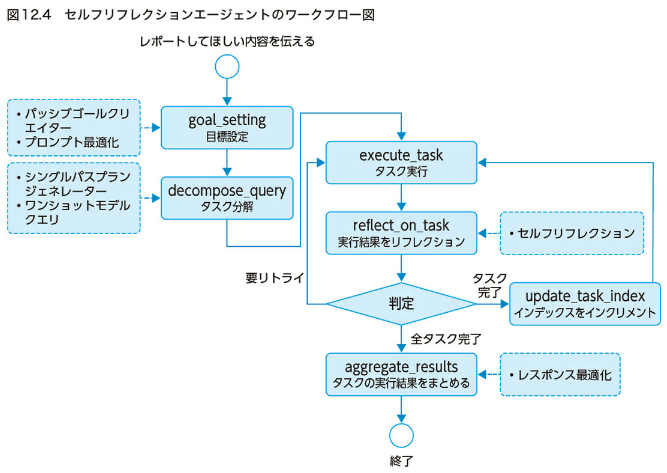

In [ ]:
from IPython.display import Image

Image("/content/drive/MyDrive/for_study_in_library/study_LangGraph/png/selfr.png")

`reflect_on_task`ノードにより実行結果をリフレクションし、その結果によって次にどのノードへ遷移するかを決定する


In [1]:
# !pip install langchain-core==0.3.0 langchain-community==0.3.0 \
# langgraph==0.2.22 langchain-openai==0.2.0 langchain-anthropic==0.2.0 \
# numpy==1.26.4 faiss-cpu==1.8.0.post1 \
# pydantic-settings==2.5.2 retry==0.9.2 decorator==4.4.2

In [2]:
# !pip install "pydantic<2.11"  # 例: 2.10.6 エラー回避用

In [5]:
import os

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [6]:
import operator
from datetime import datetime
from typing import Annotated, Any, Optional
import json
import os
import uuid

import faiss
import numpy as np
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import create_react_agent
from passive_goal_creator.main import Goal, PassiveGoalCreator
from prompt_optimizer.main import OptimizedGoal, PromptOptimizer
from pydantic import BaseModel, Field
from response_optimizer.main import ResponseOptimizer
from retry import retry
from pprint import pprint
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import HumanMessage, AIMessage

## タスクリフレクション用クラス実装

- `TaskReflector`クラス：タスクの実行結果のリフレクションを行う
- `ReflectionManager`クラス：上記内容をデータベースに登録したり、類似度検索を行う

### データモデル

- LLM が理解しやすいように詳細に description に記述


In [ ]:
class ReflectionJudgment(BaseModel):
    needs_retry: bool = Field(
        description="タスクの実行結果は適切だったと思いますか?あなたの判断を真偽値で示してください。"
    )
    confidence: float = Field(
        description="あなたの判断に対するあなたの自信の度合いを0から1までの小数で示してください。"
    )
    reasons: list[str] = Field(
        description="タスクの実行結果の適切性とそれに対する自信度について、判断に至った理由を簡潔に列挙してください。"
    )


class Reflection(BaseModel):
    id: str = Field(description="リフレクション内容に一意性を与えるためのID")
    task: str = Field(description="ユーザーから与えられたタスクの内容")
    reflection: str = Field(
        description="このタスクに取り組んだ際のあなたの思考プロセスを振り返ってください。何か改善できる点はありましたか? 次に同様のタスクに取り組む際に、より良い結果を出すための教訓を2〜3文程度で簡潔に述べてください。"
    )
    judgment: ReflectionJudgment = Field(description="リトライが必要かどうかの判定")

### 共通関数

- レフレクションの内容をプロンプト向けのテキストに整形


In [8]:
def format_reflections(reflections: list[Reflection]) -> str:
    return (
        "\n\n".join(
            f"<ref_{i}><task>{r.task}</task><reflection>{r.reflection}</reflection></ref_{i}>"
            for i, r in enumerate(reflections)
        )
        if reflections
        else "No relevant past reflections."
    )

### リフレクションマネージャ

- タスクリフレクター(`TaskReflector`)によって生成したリフレクション内容を管理するための機能（DB 機能）を提供
- リフレクション内容を UUID で裁判して保存、裁判された UUID からデータ取得、類似度検索による関連する過去のリフレクション内容を抽出できる簡易なベクトル DB
- データベースの内容は JSON ファイルとして保存
- 類似度検索は Faiss を利用


In [ ]:
class ReflectionManager:
    def __init__(
        self,
        file_path: str = "/content/drive/MyDrive/for_study_in_library/study_LangGraph/reflection_db.json",
    ):
        self.file_path = file_path
        self.embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
        self.reflections: dict[str, Reflection] = {}
        self.embeddings_dict: dict[str, list[float]] = {}
        self.index = None
        self.load_reflections()

    def load_reflections(self):
        if os.path.exists(self.file_path):
            with open(self.file_path, "r") as file:
                data = json.load(file)
                for item in data:
                    reflection = Reflection(**item["reflection"])
                    self.reflections[reflection.id] = reflection
                    self.embeddings_dict[reflection.id] = item["embedding"]

            if self.reflections:
                embeddings = list(self.embeddings_dict.values())
                self.index = faiss.IndexFlatL2(len(embeddings[0]))
                self.index.add(np.array(embeddings).astype("float32"))

    def save_reflection(self, reflection: Reflection) -> str:
        reflection.id = str(uuid.uuid4())
        reflection_id = reflection.id
        self.reflections[reflection_id] = reflection
        embedding = self.embeddings.embed_query(reflection.reflection)
        self.embeddings_dict[reflection_id] = embedding

        if self.index is None:
            self.index = faiss.IndexFlatL2(len(embedding))
        self.index.add(np.array([embedding]).astype("float32"))

        with open(self.file_path, "w", encoding="utf-8") as file:
            json.dump(
                [
                    {"reflection": reflection.dict(), "embedding": embedding}
                    for reflection, embedding in zip(
                        self.reflections.values(), self.embeddings_dict.values()
                    )
                ],
                file,
                ensure_ascii=False,
                indent=4,
            )

        return reflection_id

    def get_reflection(self, reflection_id: str) -> Optional[Reflection]:
        return self.reflections.get(reflection_id)

    def get_relevant_reflections(self, query: str, k: int = 3) -> list[Reflection]:
        if not self.reflections or self.index is None:
            return []

        query_embedding = self.embeddings.embed_query(query)
        try:
            D, I = self.index.search(
                np.array([query_embedding]).astype("float32"),
                min(k, len(self.reflections)),
            )
            reflection_ids = list(self.reflections.keys())
            return [
                self.reflections[reflection_ids[i]]
                for i in I[0]
                if i < len(reflection_ids)
            ]
        except Exception as e:
            print(f"Error during reflection search: {e}")
            return []

- `load_reflections`メソッド
  - 所定のファイルパスから JSON データを読み出し、Faiss にロード
- `save_reflection`メソッド
  - DB に Reflection 型のオブジェクトを保存。成功すると、DB に登録する際に生成したユニーク ID（UUID）を返す
- `get_reflection`メソッド
  - `save_reflection`メソッドによって返ってきたユニーク ID をもとに、データを抽出
- `get_relevant_reflections`メソッド
  - クエリ内容と類似したリフレクションのリストを DB から抽出

#### Faiss（Faicebook AI Similarity Search）

- 近似最近傍探索(ANN)用パッケージ


### タスクリフレクター

- タスクの内容と実行結果を引数に取り、`Reflection`型のオブジェクトを返す
- モデルによっては`with_structured_output`関数による`Reflectio`型への変換に失敗する場合もあるため、チェーンの実行を最大 5 回リトライする
- `Reflection`型のオブジェクトが生成できたあとは、そのオブジェクトをリフレクションマネージャに保存


In [10]:
### タスクリフレクター
class TaskReflector:
    def __init__(self, llm: BaseChatModel, reflection_manager: ReflectionManager):
        self.llm = llm.with_structured_output(Reflection)
        self.reflection_manager = reflection_manager

    def run(self, task: str, result: str) -> Reflection:
        prompt = ChatPromptTemplate.from_template(
            "与えられたタスクの内容:\n{task}\n\n"
            "タスクを実行した結果:\n{result}\n\n"
            "あなたは高度な推論能力を持つAIエージェントです。上記のタスクを実行した結果を分析し、このタスクに対するあなたの取り組みが適切だったかどうかを内省してください。\n"
            "以下の項目に沿って、リフレクションの内容を出力してください。\n\n"
            "リフレクション:\n"
            "このタスクに取り組んだ際のあなたの思考プロセスや方法を振り返ってください。何か改善できる点はありましたか?\n"
            "次に同様のタスクに取り組む際に、より良い結果を出すための教訓を2〜3文程度で簡潔に述べてください。\n\n"
            "判定:\n"
            "- 結果の適切性: タスクの実行結果は適切だったと思いますか?あなたの判断を真偽値で示してください。\n"
            "- 判定の自信度: 上記の判断に対するあなたの自信の度合いを0から1までの小数で示してください。\n"
            "- 判定の理由: タスクの実行結果の適切性とそれに対する自信度について、判断に至った理由を簡潔に列挙してください。\n\n"
            "出力は必ず日本語で行ってください。\n\n"
            "Tips: Make sure to answer in the correct format."
        )

        chain = prompt | self.llm

        @retry(tries=5)
        def invoke_chain() -> Reflection:
            return chain.invoke({"task": task, "result": result})

        reflection = invoke_chain()
        reflection_id = self.reflection_manager.save_reflection(reflection)
        reflection.id = reflection_id

        return reflection

### ステート設計


In [ ]:
class DecomposedTasks(BaseModel):
    values: list[str] = Field(
        default_factory=list,
        min_items=3,
        max_items=5,
        description="3~5個に分解されたタスク",
    )


class ReflectiveAgentState(BaseModel):
    query: str = Field(..., description="ユーザーが最初に入力したクエリ")
    optimized_goal: str = Field(default="", description="最適化された目標")
    optimized_response: str = Field(
        default="", description="最適化されたレスポンス定義"
    )
    tasks: list[str] = Field(default_factory=list, description="実行するタスクのリスト")
    current_task_index: int = Field(default=0, description="現在実行中のタスクの番号")
    results: Annotated[list[str], operator.add] = Field(
        default_factory=list, description="実行済みタスクの結果リスト"
    )
    reflection_ids: Annotated[list[str], operator.add] = Field(
        default_factory=list, description="リフレクション結果のIDリスト"
    )
    final_output: str = Field(default="", description="最終的な出力結果")
    retry_count: int = Field(default=0, description="タスクの再試行回数")

## ノード実装

## `goal_setting`ノード：目標設定

- 実行時に保存されたリフレクション結果を各処理で呼び出し、参考にするようプロンプトに指示を加える
- プロンプト最適化のクエリにユーザーの目標と関連するリフレクション結果を含める


In [12]:
class ReflectiveGoalCreator:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm
        self.reflection_manager = reflection_manager
        self.passive_goal_creator = PassiveGoalCreator(llm=self.llm)
        self.prompt_optimizer = PromptOptimizer(llm=self.llm)

    def run(self, query: str) -> str:
        relevant_reflections = self.reflection_manager.get_relevant_reflections(query)
        reflection_text = format_reflections(relevant_reflections)

        query = f"{query}\n\n目標設定する際に以下の過去のふりかえりを考慮すること:\n{reflection_text}"
        goal: Goal = self.passive_goal_creator.run(query=query)
        optimized_goal: OptimizedGoal = self.prompt_optimizer.run(query=goal.text)

        # debug用
        print("\nquery：\n")
        pprint(f"{query}")
        print("\n過去のリフレクション情報：\n")
        pprint(f"{reflection_text}")
        print("\npassive_goal_creator:\n")
        pprint(f"{goal.text}")
        print("\npromppt_optimizer:\n")
        pprint(f"{optimized_goal.text}")

        return optimized_goal.text

### レスポンス最適化

- リフレクションの内容を加味してレスポンス仕様の定義を行う


In [13]:
class ReflectiveResponseOptimizer:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm
        self.reflection_manager = reflection_manager
        self.response_optimizer = ResponseOptimizer(llm=llm)

    def run(self, query: str) -> str:
        relevant_reflections = self.reflection_manager.get_relevant_reflections(query)
        reflection_text = format_reflections(relevant_reflections)

        query = f"{query}\n\nレスポンス最適化に以下の過去のふりかえりを考慮すること:\n{reflection_text}"
        optimized_response: str = self.response_optimizer.run(query=query)

        # debug用
        print("\nquery：\n")
        pprint(f"{query}")
        print("\n過去のリフレクション情報：\n")
        pprint(f"{reflection_text}")
        print("\nresponse_optimizer:\n")
        pprint(f"{optimized_response}")

        return optimized_response

#### `goal_setting`ノードの実装コード

```python
def _goal_setting(self, state: ReflectiveAgentState) -> dict[str, Any]:
    optimized_goal: str = self.reflective_goal_creator.run(query=state.query)
    optimized_response: str = self.reflective_response_optimizer.run(query=optimized_goal)

    return {
        "optimized_goal": optimized_goal,
        "optimized_response": optimized_response
    }
```


## `decomposed_query`ノード：タスク分解

- これまでのリフレクション結果を加味する


In [14]:
class QueryDecomposer:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm.with_structured_output(DecomposedTasks)
        self.current_date = datetime.now().strftime("%Y-%m-%d")
        self.reflection_manager = reflection_manager

    def run(self, query: str) -> DecomposedTasks:
        relevant_reflections = self.reflection_manager.get_relevant_reflections(query)
        reflection_text = format_reflections(relevant_reflections)
        prompt = ChatPromptTemplate.from_template(
            f"CURRENT_DATE: {self.current_date}\n"
            "-----\n"
            "タスク: 与えられた目標を具体的で実行可能なタスクに分解してください。\n"
            "要件:\n"
            "1. 以下の行動だけで目標を達成すること。決して指定された以外の行動をとらないこと。\n"
            "   - インターネットを利用して、目標を達成するための調査を行う。\n"
            "2. 各タスクは具体的かつ詳細に記載されており、単独で実行ならびに検証可能な情報を含めること。一切抽象的な表現を含まないこと。\n"
            "3. タスクは実行可能な順序でリスト化すること。\n"
            "4. タスクは日本語で出力すること。\n"
            "5. タスクを作成する際に以下の過去のふりかえりを考慮すること:\n{reflections}\n\n"
            "目標: {query}"
        )
        chain = prompt | self.llm
        tasks = chain.invoke({"query": query, "reflections": reflection_text})

        # debug用
        print("\nquery：\n")
        pprint(f"{query}")
        print("\n過去のリフレクション情報：\n")
        pprint(f"{reflection_text}")

        print("\nquery_decomposer:\n")
        pprint(f"{tasks}")

        return tasks

#### `decomposed_query`ノードの実装コード

```python
def _decompose_query(self, state: ReflectiveAgentState) -> dict[str, Any]:
    tasks: DecomposedTaks = self.query_decomposer.run(query=state.optimized_goal)

    return {"tasks": tasks. values}
```


## `execute_task`ノード：タスク実行

- タスク実行も同様にリフレクション結果を参照


In [ ]:
class TaskExecutor:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm
        self.reflection_manager = reflection_manager
        self.current_date = datetime.now().strftime("%Y-%m-%d")
        self.tools = [TavilySearchResults(max_results=3)]

        # 1度だけメモリ＋エージェントを作成して保持
        self.memory = ConversationBufferMemory(
            return_messages=True,  # agent が messages を受け取れる
            memory_key="messages",  # 参照用キー名
        )
        # self.agent = create_react_agent(
        #     self.llm,
        #     self.tools,
        #     memory=self.memory # <-memory引数は存在しない！！！
        # )
        self.agent = create_react_agent(self.llm, self.tools)

    def run(self, task: str, goal: str) -> str:
        relevant_reflections = self.reflection_manager.get_relevant_reflections(task)
        reflection_text = format_reflections(relevant_reflections)
        # agent = create_react_agent(self.llm, self.tools)
        # result = agent.invoke(
        #     {
        #         "messages": [
        #             (
        #                 "human",
        #                 f"CURRENT_DATE: {self.current_date}\n"
        #                 "-----\n"
        #                 f"次のタスクを実行し、詳細な回答を提供してください。\n\nタスク: {task}\n\n"
        #                 "要件:\n"
        #                 "1. 必要に応じて提供されたツールを使用すること。\n"
        #                 "2. 実行において徹底的かつ包括的であること。\n"
        #                 "3. 可能な限り具体的な事実やデータを提供すること。\n"
        #                 "4. 発見事項を明確に要約すること。\n"
        #                 f"5. 以下の過去のふりかえりを考慮すること:\n{reflection_text}\n",
        #             )
        #         ]
        #     }
        # )

        # 過去メッセージを取得
        past_msgs = self.memory.load_memory_variables({})["messages"]
        # BaseMessage → ("role", "content") に変換
        past_as_tuples = [(m.type, m.content) for m in past_msgs]

        system_prompt = (
            "あなたはWebリサーチャです。以下の『目標』を必ず頭に置き、"
            "その目標達成に直接役立つ形でタスクを実行してください。"
        )
        human_prompt = (
            f"目標: {goal}\n\n"
            f"タスク: {task}\n\n"
            "要件:\n"
            "1. 必ず目標と関連する情報のみを検索すること。\n"
            "2. 必要に応じて提供ツールを使う。\n"
            "3. 実行は徹底的かつ具体的に。\n"
            "4. 発見を明確に要約すること。\n"
            f"5. 以下の過去のふりかえりを考慮すること:\n{reflection_text}\n"
        )

        # 過去 → system → human の順に連結
        messages = past_as_tuples + [
            ("system", system_prompt),
            ("human", human_prompt),
        ]

        result = self.agent.invoke({"messages": messages})

        # result = agent.invoke(
        #     {"messages": [("system", system_prompt), ("human", human_prompt)]}
        # )

        # 今回の human / ai をメモリに追加
        self.memory.chat_memory.add_message(HumanMessage(content=human_prompt))
        self.memory.chat_memory.add_message(
            AIMessage(content=result["messages"][-1].content)
        )

        ## debug用
        print("\nーーーーtaskーーーー：\n")
        pprint(f"{task}")
        print("\nーーーーmessagesーーーー：\n")
        pprint(f"{messages}")
        # print("\n過去のリフレクション情報：\n")
        # pprint(f"{reflection_text}")

        print("\nーーーー検索結果ーーーー：\n")
        pprint(f"{result['messages'][-1].content}\n")
        print("=================================================================")

        return result["messages"][-1].content

#### `execute_task`ノードの実装コード

```python
def _excecute_task(self, state: ReflectiveAgentState) -> dict[str, Any]:
    current_task = state.tasks[state.current_task_index]
    result = self.task_executor.run(task=current_task, goal=state.optimized_goal)
    return {
        "result": [result],
        "current_task_index": state.current_task_index
    }
```


## `reflect_on_task`ノード：実行結果をリフレクション

- 直前に実行したタスクの内容についてリフレクションを実施する責務を担う。
- タスクリフレクターを利用してリフレクションを実行し、DB に永続された ID をステートに保存する

```python
def __reflect_on_task(self, state: ReflectiveAgentState) -> dict[str, Any]:
    current_task = state.tasks[state.current_task_index]
    current_result = state.results[-1]
    reflection = self.task_reflection.run(task=current_task, result=current_result)

    # ★ Retry が必要と判断されたなら TaskExecutor のメモリをクリア
    if reflection.judgment.needs_retry:
        self.task_executor.memory.clear()

    return {
        "reflection_ids": [reflection.id],
        "retry_count": (
            state.retry_count + 1 if reflection.judgement.needs_retry else 0
        ),
    }
```

- リフレクションの結果リトライが必要なった場合は、リトライカウントをインクリメントする


## 条件付きエッジ：リフレクション結果によるノード分岐

- 条件付きエッジにより、リフレクション結果から次に進むコードを変更する
- 直近のリフレクションの結果を取得したうえで、次の判断を行う
  - 最大試行回数に満たず、リトライが必要な場合：リトライする
  - まだ他のタスクがの買っている場合：次のタスクを実行する
  - すべてのタスクが完了した場合：タスク実行を終了する

```python
def _should_retry_or_continue(self, state: ReflectiveAgentState) -> str:
    latest_reflection_id = state.reflection_ids[-1]
    latest_reflection = self.reflection_manager.get_reflection(latest_reflection_id)
    if (
        latest_reflection
        and latest_reflection.judgement.needs_retry
        and state.retry_count < self.max_retries
    ):
        return "retry"

    elif state.current_task_index < len(state.tasks) - 1:
        return "continue"

    else:
        return "finish"
```

このメソッドを、次のように条件付きメソッドとして設定

```python
graph.add_conditional_edges(
    "reflect_on_task",
    self._should_retry_or_continue,
    {
        "retry": "execute_task",
        "continue": "update_task_index",
        "finish": "aggregate_results",
    }
)
```

このように定義することで、`shuold_retry_on_continue`関数の戻り値が`retry`の場合は`execute_task`ノード、`continue`の場合は`updata_task_index`ノード、`finish`の場合は`aggregate_results`ノードが実行される


## `update_task_index`ノード：インデックスをインクリメント

- 現在のタスクのインデックスをインクリメントする

```python
def _updata_task_index(self, state: TaskExecutionState) -> dict[str, Any]:
    return {
        "current_task_index": state.current_task_index + 1
    }
```


## `aggregate_results`ノード：タスクの実行結果をまとめる

- これまで実行してきたタスクの実行結果をまとめ、レポートを生成
- レポート生成を担当する`ResultAggregator`クラスでは、一連のタスクのリフレクション結果と、レスポンス最適化によって生成されたレスポンス仕様の定義を参照し、レポート生成を実行


In [ ]:
class ResultAggregator:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm
        self.reflection_manager = reflection_manager
        self.current_date = datetime.now().strftime("%Y-%m-%d")

    def run(
        self,
        query: str,
        results: list[str],
        reflection_ids: list[str],
        response_definition: str,
    ) -> str:
        relevant_reflections = [
            self.reflection_manager.get_reflection(rid) for rid in reflection_ids
        ]
        prompt = ChatPromptTemplate.from_template(
            "与えられた目標:\n{query}\n\n"
            "調査結果:\n{results}\n\n"
            "与えられた目標に対し、調査結果を用いて、以下の指示に基づいてレスポンスを生成してください。\n"
            "{response_definition}\n\n"
            "過去のふりかえりを考慮すること:\n{reflection_text}\n"
        )
        chain = prompt | self.llm | StrOutputParser()

        # debug用
        print("\nresult_aggregatorでの振り返り内容:\n")
        pprint(f"{format_reflections(relevant_reflections)}")

        return chain.invoke(
            {
                "query": query,
                "results": "\n\n".join(
                    f"Info {i + 1}:\n{result}" for i, result in enumerate(results)
                ),
                "response_definition": response_definition,
                "reflection_text": format_reflections(relevant_reflections),
            }
        )


#### `aggregate_result`の実装コード

```python
def _aggregate_results(self, state: ReflectiveAgentSate) -> dict[str, Any]:
    final_output = self.result_aggregator.run(
        query=state.optimized_goal,
        results=state.results,
        reflection_ids=state.reflection_ids,
        response_definition=state.optimized_response,
    )
    return {"final_output": final_output}
```


## Graph 作成

- ノード、エッジ設定


In [17]:
class ReflectiveAgent:
    def __init__(
        self,
        llm: ChatOpenAI,
        reflection_manager: ReflectionManager,
        task_reflector: TaskReflector,
        max_retries: int = 2,
    ):
        self.reflection_manager = reflection_manager
        self.task_reflector = task_reflector
        self.reflective_goal_creator = ReflectiveGoalCreator(
            llm=llm, reflection_manager=self.reflection_manager
        )
        self.reflective_response_optimizer = ReflectiveResponseOptimizer(
            llm=llm, reflection_manager=self.reflection_manager
        )
        self.query_decomposer = QueryDecomposer(
            llm=llm, reflection_manager=self.reflection_manager
        )
        self.task_executor = TaskExecutor(
            llm=llm, reflection_manager=self.reflection_manager
        )
        self.result_aggregator = ResultAggregator(
            llm=llm, reflection_manager=self.reflection_manager
        )
        self.max_retries = max_retries
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        graph = StateGraph(ReflectiveAgentState)
        graph.add_node("goal_setting", self._goal_setting)
        graph.add_node("decompose_query", self._decompose_query)
        graph.add_node("execute_task", self._execute_task)
        graph.add_node("reflect_on_task", self._reflect_on_task)
        graph.add_node("update_task_index", self._update_task_index)
        graph.add_node("aggregate_results", self._aggregate_results)

        graph.set_entry_point("goal_setting")
        graph.add_edge("goal_setting", "decompose_query")
        graph.add_edge("decompose_query", "execute_task")
        graph.add_edge("execute_task", "reflect_on_task")
        graph.add_conditional_edges(
            "reflect_on_task",
            self._should_retry_or_continue,
            {
                "retry": "execute_task",
                "continue": "update_task_index",
                "finish": "aggregate_results",
            },
        )
        graph.add_edge("update_task_index", "execute_task")
        graph.add_edge("aggregate_results", END)
        return graph.compile()

    def _goal_setting(self, state: ReflectiveAgentState) -> dict[str, Any]:
        optimized_goal: str = self.reflective_goal_creator.run(query=state.query)
        optimized_response: str = self.reflective_response_optimizer.run(
            query=optimized_goal
        )
        return {
            "optimized_goal": optimized_goal,
            "optimized_response": optimized_response,
        }

    def _decompose_query(self, state: ReflectiveAgentState) -> dict[str, Any]:
        tasks: DecomposedTasks = self.query_decomposer.run(query=state.optimized_goal)
        return {"tasks": tasks.values}

    def _execute_task(self, state: ReflectiveAgentState) -> dict[str, Any]:
        current_task = state.tasks[state.current_task_index]
        result = self.task_executor.run(task=current_task, goal=state.optimized_goal)
        return {"results": [result], "current_task_index": state.current_task_index}

    def _reflect_on_task(self, state: ReflectiveAgentState) -> dict[str, Any]:
        current_task = state.tasks[state.current_task_index]
        current_result = state.results[-1]
        reflection = self.task_reflector.run(task=current_task, result=current_result)

        # ★ Retry が必要と判断されたなら TaskExecutor のメモリをクリア
        if reflection.judgment.needs_retry:
            self.task_executor.memory.clear()

        return {
            "reflection_ids": [reflection.id],
            "retry_count": (
                state.retry_count + 1 if reflection.judgment.needs_retry else 0
            ),
        }

    def _should_retry_or_continue(self, state: ReflectiveAgentState) -> str:
        latest_reflection_id = state.reflection_ids[-1]
        latest_reflection = self.reflection_manager.get_reflection(latest_reflection_id)
        if (
            latest_reflection
            and latest_reflection.judgment.needs_retry
            and state.retry_count < self.max_retries
        ):
            return "retry"
        elif state.current_task_index < len(state.tasks) - 1:
            return "continue"
        else:
            return "finish"

    def _update_task_index(self, state: ReflectiveAgentState) -> dict[str, Any]:
        return {"current_task_index": state.current_task_index + 1}

    def _aggregate_results(self, state: ReflectiveAgentState) -> dict[str, Any]:
        final_output = self.result_aggregator.run(
            query=state.optimized_goal,
            results=state.results,
            reflection_ids=state.reflection_ids,
            response_definition=state.optimized_response,
        )
        return {"final_output": final_output}

    def run(self, query: str) -> str:
        initial_state = ReflectiveAgentState(query=query)
        final_state = self.graph.invoke(initial_state, {"recursion_limit": 1000})
        return final_state.get("final_output", "エラー: 出力に失敗しました。")

## 実行１


In [ ]:
query = "カレーライスの作り方"

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

reflection_manager = ReflectionManager(
    file_path="/content/drive/MyDrive/for_study_in_library/study_LangGraph/self_reflection_db.json"
)

task_reflector = TaskReflector(llm=llm, reflection_manager=reflection_manager)

agent = ReflectiveAgent(
    llm=llm, reflection_manager=reflection_manager, task_reflector=task_reflector
)
result = agent.run(query=query)
pprint(result)


query：

'カレーライスの作り方\n\n目標設定する際に以下の過去のふりかえりを考慮すること:\nNo relevant past reflections.'

過去のリフレクション情報：

'No relevant past reflections.'

passive_goal_creator:

'カレーライスを作るための具体的な手順を理解し、必要な材料と調理方法を明確にする。'

promppt_optimizer:

('カレーライスを作るために、必要な材料（米、カレールー、肉、野菜など）をリストアップし、調理手順（米の炊き方、具材の切り方、ルーの溶かし方など）を詳細に理解する。(測定基準: '
 '材料リストと調理手順を含むレポートを作成し、レポートの内容が正確であるかを確認するために、実際にカレーライスを作ってみて、味や見た目が満足できるかを評価する。)')

query：

('カレーライスを作るために、必要な材料（米、カレールー、肉、野菜など）をリストアップし、調理手順（米の炊き方、具材の切り方、ルーの溶かし方など）を詳細に理解する。(測定基準: '
 '材料リストと調理手順を含むレポートを作成し、レポートの内容が正確であるかを確認するために、実際にカレーライスを作ってみて、味や見た目が満足できるかを評価する。)\n'
 '\n'
 'レスポンス最適化に以下の過去のふりかえりを考慮すること:\n'
 'No relevant past reflections.')

過去のリフレクション情報：

'No relevant past reflections.'

response_optimizer:

('目標分析:\n'
 'カレーライスを作るためのレスポンスは、必要な材料と調理手順を明確に示すことが求められています。主要な要素は、材料のリストアップ（米、カレールー、肉、野菜など）と、調理手順（米の炊き方、具材の切り方、ルーの溶かし方など）です。意図は、ユーザーが自宅で簡単にカレーライスを作れるようにすることです。\n'
 '\n'
 'レスポンス仕様:\n'
 'トーンは親しみやすく、分かりやすいもので、初心者でも理解できるようにします。構造は、材料リストを最初に提示し、その後に調理手順を段階的に説明する形式とします。内容の焦点は、具体

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'米の炊き方を理解するために、インターネットで米の炊き方に関する動画や記事を探し、手順をメモする。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'カレーライスを作るために、必要な材料（米、カレールー、肉、野菜など）をリストアップし、調理手順（米の炊き方、具材の切り方、ルーの溶かし方など）を詳細に理解する。(測定基準: '
 '材料リストと調理手順を含むレポートを作成し、レポートの内容が正確であるかを確認するために、実際にカレーライスを作ってみて、味や見た目が満足できるかを評価する。)\\n\\nタスク: '
 'カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 "発見を明確に要約すること。\\n5. 以下の過去のふりかえりを考慮すること:\\nNo relevant past reflections.\\n'), "
 "('ai', 'カレーライスを作るために必要な材料と調理手順を以下にまとめました。\\n\\n### 材料リスト（4人分）\\n\\n1. "
 '**基本材料**\\n   - 米（白ご飯）: 適量\\n   - カレールー: 90g〜100g（例: '
 'ゴールデンカレー中辛、ジャワカレー中辛など）\\n   - 水: 800ml\\n\\n2. **具材**\\n   - 玉ねぎ: '
 '1/2〜1玉（約200g）\\n   - 人参: 1本（約200g）\\n   - じゃがいも: 2個（約200g）\\n   - '
 '肉（豚バラ肉または豚肩ロース肉）: 150g〜200g\\n   - ニンニク: 2片\\n   - 生姜: 10g\\n   - '
 'オリーブ油またはサラダ油: 大さじ1\\n   - 鶏がらスープの素: 大さじ1/2（オプション）\\n   - オイスターソース: '
 '大さじ1（オプション）\\n   - ダークチョコ: 10g（隠し味、オプション）\\n\\n3. **その他**\\n   - 塩

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'カレーの具材（肉や野菜）の切り方を調べるために、インターネットで具材の切り方に関する情報を探し、具体的な手順を記録する。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'カレーライスを作るために、必要な材料（米、カレールー、肉、野菜など）をリストアップし、調理手順（米の炊き方、具材の切り方、ルーの溶かし方など）を詳細に理解する。(測定基準: '
 '材料リストと調理手順を含むレポートを作成し、レポートの内容が正確であるかを確認するために、実際にカレーライスを作ってみて、味や見た目が満足できるかを評価する。)\\n\\nタスク: '
 'カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 "発見を明確に要約すること。\\n5. 以下の過去のふりかえりを考慮すること:\\nNo relevant past reflections.\\n'), "
 "('ai', 'カレーライスを作るために必要な材料と調理手順を以下にまとめました。\\n\\n### 材料リスト（4人分）\\n\\n1. "
 '**基本材料**\\n   - 米（白ご飯）: 適量\\n   - カレールー: 90g〜100g（例: '
 'ゴールデンカレー中辛、ジャワカレー中辛など）\\n   - 水: 800ml\\n\\n2. **具材**\\n   - 玉ねぎ: '
 '1/2〜1玉（約200g）\\n   - 人参: 1本（約200g）\\n   - じゃがいも: 2個（約200g）\\n   - '
 '肉（豚バラ肉または豚肩ロース肉）: 150g〜200g\\n   - ニンニク: 2片\\n   - 生姜: 10g\\n   - '
 'オリーブ油またはサラダ油: 大さじ1\\n   - 鶏がらスープの素: 大さじ1/2（オプション）\\n   - オイスターソース: '
 '大さじ1（オプション）\\n   - ダークチョコ: 10g（隠し味、オプション）\\n\\n3. **その

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'カレールーの溶かし方を理解するために、インターネットでカレールーの調理方法に関する情報を検索し、詳細な手順をまとめる。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'カレーライスを作るために、必要な材料（米、カレールー、肉、野菜など）をリストアップし、調理手順（米の炊き方、具材の切り方、ルーの溶かし方など）を詳細に理解する。(測定基準: '
 '材料リストと調理手順を含むレポートを作成し、レポートの内容が正確であるかを確認するために、実際にカレーライスを作ってみて、味や見た目が満足できるかを評価する。)\\n\\nタスク: '
 'カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 "発見を明確に要約すること。\\n5. 以下の過去のふりかえりを考慮すること:\\nNo relevant past reflections.\\n'), "
 "('ai', 'カレーライスを作るために必要な材料と調理手順を以下にまとめました。\\n\\n### 材料リスト（4人分）\\n\\n1. "
 '**基本材料**\\n   - 米（白ご飯）: 適量\\n   - カレールー: 90g〜100g（例: '
 'ゴールデンカレー中辛、ジャワカレー中辛など）\\n   - 水: 800ml\\n\\n2. **具材**\\n   - 玉ねぎ: '
 '1/2〜1玉（約200g）\\n   - 人参: 1本（約200g）\\n   - じゃがいも: 2個（約200g）\\n   - '
 '肉（豚バラ肉または豚肩ロース肉）: 150g〜200g\\n   - ニンニク: 2片\\n   - 生姜: 10g\\n   - '
 'オリーブ油またはサラダ油: 大さじ1\\n   - 鶏がらスープの素: 大さじ1/2（オプション）\\n   - オイスターソース: '
 '大さじ1（オプション）\\n   - ダークチョコ: 10g（隠し味、オプション）\\n\\n3. **その他

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'材料リストと調理手順を含むレポートを作成し、実際にカレーライスを作ってみて、味や見た目を評価する。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'カレーライスを作るために、必要な材料（米、カレールー、肉、野菜など）をリストアップし、調理手順（米の炊き方、具材の切り方、ルーの溶かし方など）を詳細に理解する。(測定基準: '
 '材料リストと調理手順を含むレポートを作成し、レポートの内容が正確であるかを確認するために、実際にカレーライスを作ってみて、味や見た目が満足できるかを評価する。)\\n\\nタスク: '
 'カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 "発見を明確に要約すること。\\n5. 以下の過去のふりかえりを考慮すること:\\nNo relevant past reflections.\\n'), "
 "('ai', 'カレーライスを作るために必要な材料と調理手順を以下にまとめました。\\n\\n### 材料リスト（4人分）\\n\\n1. "
 '**基本材料**\\n   - 米（白ご飯）: 適量\\n   - カレールー: 90g〜100g（例: '
 'ゴールデンカレー中辛、ジャワカレー中辛など）\\n   - 水: 800ml\\n\\n2. **具材**\\n   - 玉ねぎ: '
 '1/2〜1玉（約200g）\\n   - 人参: 1本（約200g）\\n   - じゃがいも: 2個（約200g）\\n   - '
 '肉（豚バラ肉または豚肩ロース肉）: 150g〜200g\\n   - ニンニク: 2片\\n   - 生姜: 10g\\n   - '
 'オリーブ油またはサラダ油: 大さじ1\\n   - 鶏がらスープの素: 大さじ1/2（オプション）\\n   - オイスターソース: '
 '大さじ1（オプション）\\n   - ダークチョコ: 10g（隠し味、オプション）\\n\\n3. **その他**\\n   - 

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



result_aggregatorでの振り返り内容:

('<ref_0><task>カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。</task><reflection>このタスクに取り組む際、インターネットでの情報収集を行い、一般的なカレーライスの材料を網羅的にリストアップしました。改善点としては、オプションの材料についても具体的な使用例や効果を説明することで、より多様なアプローチを提案できたかもしれません。次回は、材料の選択肢や調理法のバリエーションをさらに詳しく説明することで、より良い結果を出せると思います。</reflection></ref_0>\n'
 '\n'
 '<ref_1><task>米の炊き方を理解するために、インターネットで米の炊き方に関する動画や記事を探し、手順をメモする。</task><reflection>このタスクに取り組む際、信頼できる情報源からの手順をまとめることに注力しました。改善点としては、実際に炊飯を行った後のフィードバックを追加することで、より実践的な内容にできたかもしれません。次回は、手順を実行した後の結果や感想を記録し、より具体的なアドバイスを提供できるようにしたいです。</reflection></ref_1>\n'
 '\n'
 '<ref_2><task>カレーの具材（肉や野菜）の切り方を調べるために、インターネットで具材の切り方に関する情報を探し、具体的な手順を記録する。</task><reflection>このタスクでは、カレーの具材の切り方を具体的に調べ、分かりやすくまとめることができました。改善点としては、切り方の写真や動画を追加することで、視覚的に理解しやすくすることができたかもしれません。次回は、情報源の多様性を考慮し、異なるレシピや切り方のスタイルを比較することで、より包括的な情報を提供できるようにしたいです。</reflection></ref_2>\n'
 '\n'
 '<ref_3><task>カレールーの溶かし方を理解するために、インターネットでカレールーの調理方法に関する情報を検索し、詳細な手順をまとめる。</task><reflection>このタスクに取り組む際、信頼できる情報源からの手順をまとめることに注力しました。

## 実行 2


In [ ]:
query = "オムライスの作り方"

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

reflection_manager = ReflectionManager(
    file_path="/content/drive/MyDrive/for_study_in_library/study_LangGraph/self_reflection_db.json"
)

task_reflector = TaskReflector(llm=llm, reflection_manager=reflection_manager)

agent = ReflectiveAgent(
    llm=llm, reflection_manager=reflection_manager, task_reflector=task_reflector
)
result = agent.run(query=query)
pprint(result)


query：

('オムライスの作り方\n'
 '\n'
 '目標設定する際に以下の過去のふりかえりを考慮すること:\n'
 '<ref_0><task>カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。</task><reflection>このタスクに取り組む際、インターネットでの情報収集を行い、一般的なカレーライスの材料を網羅的にリストアップしました。改善点としては、オプションの材料についても具体的な使用例や効果を説明することで、より多様なアプローチを提案できたかもしれません。次回は、材料の選択肢や調理法のバリエーションをさらに詳しく説明することで、より良い結果を出せると思います。</reflection></ref_0>\n'
 '\n'
 '<ref_1><task>材料リストと調理手順を含むレポートを作成し、実際にカレーライスを作ってみて、味や見た目を評価する。</task><reflection>このタスクに取り組む際、材料リストと調理手順を明確に整理することが重要だと感じました。次回は、調理時間や火加減の具体的な指示を追加することで、より分かりやすいレシピにできると思います。また、実際に作った際の味や見た目の評価を具体的に記録することも改善点です。</reflection></ref_1>\n'
 '\n'
 '<ref_2><task>カレーの具材（肉や野菜）の切り方を調べるために、インターネットで具材の切り方に関する情報を探し、具体的な手順を記録する。</task><reflection>このタスクでは、カレーの具材の切り方を具体的に調べ、分かりやすくまとめることができました。改善点としては、切り方の写真や動画を追加することで、視覚的に理解しやすくすることができたかもしれません。次回は、情報源の多様性を考慮し、異なるレシピや切り方のスタイルを比較することで、より包括的な情報を提供できるようにしたいです。</reflection></ref_2>')

過去のリフレクション情報：

('<ref_0><task>カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。</task><reflection>このタスクに取り組む際、イン

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'調理手順を明確にするために、オムライスの調理手順を5つのステップに分け、各ステップにかかる時間を調査してメモする。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'オムライスを作るために、必要な材料をリストアップし、一般的なレシピを調査して、調理手順を明確に整理する。具体的には、オムライスに必要な材料（米、鶏肉、玉ねぎ、卵、ケチャップなど）をリスト化し、各材料の分量を明記する。次に、調理手順を5つのステップに分け、各ステップにかかる時間（例：米を炊くのに20分、具材を切るのに10分など）を記載する。また、火加減の指示（強火、中火、弱火）を具体的に示す。さらに、具材の切り方（例：鶏肉は1cm角、玉ねぎはみじん切り）や調理法のバリエーション（例：チーズオムライス、和風オムライス）についても調査し、視覚的な情報（写真や動画）を含めたレポートを作成する。(測定基準: '
 'レポートには、必要な材料のリスト、各材料の分量、調理手順の5つのステップ、各ステップの調理時間、火加減の指示、具材の切り方、調理法のバリエーション、視覚的な情報（写真や動画）が含まれていることを確認する。)\\n\\nタスク: '
 'オムライスに必要な材料をリストアップするために、インターネットでオムライスのレシピサイトを検索し、一般的な材料とその分量を確認する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 '発見を明確に要約すること。\\n5. '
 "以下の過去のふりかえりを考慮すること:\\n<ref_0><task>カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。</task><reflection>このタスクに取り組む際、インターネットでの情報収集を行い、一般的なカレーライスの材料を網羅的にリストアップしました。改善点としては、オプションの材料についても具体的な使用例や効果を説明することで、より多様なアプローチを提案できたかもしれません。次回は、材料の選択肢や調理法のバリエーションをさらに詳しく説明することで、より良い結果を出せ

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'火加減の指示を具体的に示すために、オムライスの調理に関する動画や記事を探し、強火、中火、弱火の使い方を確認する。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'オムライスを作るために、必要な材料をリストアップし、一般的なレシピを調査して、調理手順を明確に整理する。具体的には、オムライスに必要な材料（米、鶏肉、玉ねぎ、卵、ケチャップなど）をリスト化し、各材料の分量を明記する。次に、調理手順を5つのステップに分け、各ステップにかかる時間（例：米を炊くのに20分、具材を切るのに10分など）を記載する。また、火加減の指示（強火、中火、弱火）を具体的に示す。さらに、具材の切り方（例：鶏肉は1cm角、玉ねぎはみじん切り）や調理法のバリエーション（例：チーズオムライス、和風オムライス）についても調査し、視覚的な情報（写真や動画）を含めたレポートを作成する。(測定基準: '
 'レポートには、必要な材料のリスト、各材料の分量、調理手順の5つのステップ、各ステップの調理時間、火加減の指示、具材の切り方、調理法のバリエーション、視覚的な情報（写真や動画）が含まれていることを確認する。)\\n\\nタスク: '
 'オムライスに必要な材料をリストアップするために、インターネットでオムライスのレシピサイトを検索し、一般的な材料とその分量を確認する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 '発見を明確に要約すること。\\n5. '
 "以下の過去のふりかえりを考慮すること:\\n<ref_0><task>カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。</task><reflection>このタスクに取り組む際、インターネットでの情報収集を行い、一般的なカレーライスの材料を網羅的にリストアップしました。改善点としては、オプションの材料についても具体的な使用例や効果を説明することで、より多様なアプローチを提案できたかもしれません。次回は、材料の選択肢や調理法のバリエーションをさらに詳しく説明することで、より良い結果を出せる

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'具材の切り方や調理法のバリエーションを調査するために、オムライスのレシピをいくつか比較し、鶏肉や玉ねぎの切り方、チーズオムライスや和風オムライスのレシピを収集する。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'オムライスを作るために、必要な材料をリストアップし、一般的なレシピを調査して、調理手順を明確に整理する。具体的には、オムライスに必要な材料（米、鶏肉、玉ねぎ、卵、ケチャップなど）をリスト化し、各材料の分量を明記する。次に、調理手順を5つのステップに分け、各ステップにかかる時間（例：米を炊くのに20分、具材を切るのに10分など）を記載する。また、火加減の指示（強火、中火、弱火）を具体的に示す。さらに、具材の切り方（例：鶏肉は1cm角、玉ねぎはみじん切り）や調理法のバリエーション（例：チーズオムライス、和風オムライス）についても調査し、視覚的な情報（写真や動画）を含めたレポートを作成する。(測定基準: '
 'レポートには、必要な材料のリスト、各材料の分量、調理手順の5つのステップ、各ステップの調理時間、火加減の指示、具材の切り方、調理法のバリエーション、視覚的な情報（写真や動画）が含まれていることを確認する。)\\n\\nタスク: '
 'オムライスに必要な材料をリストアップするために、インターネットでオムライスのレシピサイトを検索し、一般的な材料とその分量を確認する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 '発見を明確に要約すること。\\n5. '
 "以下の過去のふりかえりを考慮すること:\\n<ref_0><task>カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。</task><reflection>このタスクに取り組む際、インターネットでの情報収集を行い、一般的なカレーライスの材料を網羅的にリストアップしました。改善点としては、オプションの材料についても具体的な使用例や効果を説明することで、より多様なアプローチを提案できたかもしれません。次回は、材料の選択肢や調理法のバリエーショ

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'視覚的な情報を含めたレポートを作成するために、オムライスの調理過程や完成品の写真や動画をインターネットで探し、レポートに組み込む。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'オムライスを作るために、必要な材料をリストアップし、一般的なレシピを調査して、調理手順を明確に整理する。具体的には、オムライスに必要な材料（米、鶏肉、玉ねぎ、卵、ケチャップなど）をリスト化し、各材料の分量を明記する。次に、調理手順を5つのステップに分け、各ステップにかかる時間（例：米を炊くのに20分、具材を切るのに10分など）を記載する。また、火加減の指示（強火、中火、弱火）を具体的に示す。さらに、具材の切り方（例：鶏肉は1cm角、玉ねぎはみじん切り）や調理法のバリエーション（例：チーズオムライス、和風オムライス）についても調査し、視覚的な情報（写真や動画）を含めたレポートを作成する。(測定基準: '
 'レポートには、必要な材料のリスト、各材料の分量、調理手順の5つのステップ、各ステップの調理時間、火加減の指示、具材の切り方、調理法のバリエーション、視覚的な情報（写真や動画）が含まれていることを確認する。)\\n\\nタスク: '
 'オムライスに必要な材料をリストアップするために、インターネットでオムライスのレシピサイトを検索し、一般的な材料とその分量を確認する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 '発見を明確に要約すること。\\n5. '
 "以下の過去のふりかえりを考慮すること:\\n<ref_0><task>カレーライスに必要な材料をリストアップするために、インターネットでレシピサイトを検索し、一般的な材料を確認する。</task><reflection>このタスクに取り組む際、インターネットでの情報収集を行い、一般的なカレーライスの材料を網羅的にリストアップしました。改善点としては、オプションの材料についても具体的な使用例や効果を説明することで、より多様なアプローチを提案できたかもしれません。次回は、材料の選択肢や調理法のバリエーションをさらに詳しく説明することで、よ

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



result_aggregatorでの振り返り内容:

('<ref_0><task>オムライスに必要な材料をリストアップするために、インターネットでオムライスのレシピサイトを検索し、一般的な材料とその分量を確認する。</task><reflection>このタスクでは、複数のレシピサイトから情報を収集し、オムライスに必要な材料をリストアップしました。改善点としては、材料の分量をもう少し具体的に示すことができたかもしれません。また、オプションの材料についても、どのレシピで使われているかを明記すると、より分かりやすくなるでしょう。次回は、材料の選択肢や分量のバリエーションを明確に示すことを心がけます。</reflection></ref_0>\n'
 '\n'
 '<ref_1><task>オムライスの調理手順を5つのステップに分け、各ステップにかかる時間を調査してメモする。</task><reflection>このタスクでは、オムライスの調理手順を明確に分け、各ステップにかかる時間を具体的に示すことができました。改善点としては、火加減の詳細をもう少し具体的に記載することで、初心者でもより理解しやすくなると思います。次回は、視覚的な情報や写真を追加することで、さらにわかりやすい手順を提供できるようにしたいです。</reflection></ref_1>\n'
 '\n'
 '<ref_2><task>火加減の指示を具体的に示すために、オムライスの調理に関する動画や記事を探し、強火、中火、弱火の使い方を確認する。</task><reflection>このタスクに取り組む際、具体的な火加減の指示を明確にすることに注力しました。情報源を複数確認し、信頼性の高い内容を選ぶことで、正確な指示を提供できたと思います。ただし、次回は調理手順全体の流れをより詳細に把握し、火加減の調整が必要な場面を具体的に示すことができれば、さらに良い結果が得られると感じました。</reflection></ref_2>\n'
 '\n'
 '<ref_3><task>オムライスのレシピをいくつか比較し、具材の切り方や調理法のバリエーションを調査する。</task><reflection>このタスクに取り組む際、オムライスの具材の切り方や調理法のバリエーションをしっかりと整理できたと思います。ただ、

# 2. クロスリフレクション

- 実行タスクのリフレクションを、他の言語モデルや AI エージェントが実施するパターン
- ここでは、`gpt-4o-mini`でクロスリフレクションを実施

## タスクリフレクターで利用する言語モデルを変更

- セルフリフレクションで実装したクラス`ReflectiveAgent`クラスは、利用する LLM、リフレクションマネージャ、タスクリフレクターをそれぞれ引数に取るため、この中のタスクリフレクターで利用する LLM のみ変更すればよい。


In [ ]:
query = "カレーライスの作り方"

llm_4o = ChatOpenAI(model="gpt-4o", temperature=0.0)
llm_4o_mini = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

# ReflectionMangerの初期化
reflection_manager = ReflectionManager(
    file_path="/content/drive/MyDrive/for_study_in_library/study_LangGraph/self_reflection_db.json"
)

# TaskReflectorの初期化
task_reflector = TaskReflector(llm=llm_4o_mini, reflection_manager=reflection_manager)

# ReflectiveAgent初期化
agent = ReflectiveAgent(
    llm=llm_4o, reflection_manager=reflection_manager, task_reflector=task_reflector
)

result = agent.run(query=query)
pprint(result)


query：

'カレーライスの作り方\n\n目標設定する際に以下の過去のふりかえりを考慮すること:\nNo relevant past reflections.'

過去のリフレクション情報：

'No relevant past reflections.'

passive_goal_creator:

'カレーライスの作り方を学び、実際に作れるようになること。具体的には、インターネットを利用してカレーライスのレシピを調査し、その情報をもとにユーザーのための詳細なレポートを生成する。レポートには必要な材料、調理手順、調理時間、注意点などを含める。これにより、ユーザーが自宅でカレーライスを作る際のガイドとして活用できるようにする。'

promppt_optimizer:

('インターネットを利用して、カレーライスのレシピを調査し、ユーザーのための詳細なレポートを生成する。レポートには、必要な材料、調理手順、調理時間、注意点を含める。これにより、ユーザーが自宅でカレーライスを作る際のガイドとして活用できるようにする。(測定基準: '
 '生成したレポートに必要な材料、調理手順、調理時間、注意点がすべて含まれているかを確認する。また、ユーザーがそのレポートを使用して実際にカレーライスを作ることができたかどうかのフィードバックを得る。)')

query：

('インターネットを利用して、カレーライスのレシピを調査し、ユーザーのための詳細なレポートを生成する。レポートには、必要な材料、調理手順、調理時間、注意点を含める。これにより、ユーザーが自宅でカレーライスを作る際のガイドとして活用できるようにする。(測定基準: '
 '生成したレポートに必要な材料、調理手順、調理時間、注意点がすべて含まれているかを確認する。また、ユーザーがそのレポートを使用して実際にカレーライスを作ることができたかどうかのフィードバックを得る。)\n'
 '\n'
 'レスポンス最適化に以下の過去のふりかえりを考慮すること:\n'
 'No relevant past reflections.')

過去のリフレクション情報：

'No relevant past reflections.'

response_optimizer:

('目標分析:\n'
 'この目標は、ユーザーが自宅でカ

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'選定したサイトから、必要な材料、調理手順、調理時間、注意点をそれぞれ確認し、情報を収集する。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'インターネットを利用して、カレーライスのレシピを調査し、ユーザーのための詳細なレポートを生成する。レポートには、必要な材料、調理手順、調理時間、注意点を含める。これにより、ユーザーが自宅でカレーライスを作る際のガイドとして活用できるようにする。(測定基準: '
 '生成したレポートに必要な材料、調理手順、調理時間、注意点がすべて含まれているかを確認する。また、ユーザーがそのレポートを使用して実際にカレーライスを作ることができたかどうかのフィードバックを得る。)\\n\\nタスク: '
 'インターネットでカレーライスのレシピを検索し、信頼性のある料理サイトを3つ選定する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 "発見を明確に要約すること。\\n5. 以下の過去のふりかえりを考慮すること:\\nNo relevant past reflections.\\n'), "
 "('ai', "
 "'以下の3つの信頼性のある料理サイトを選定しました。これらのサイトは、カレーライスのレシピに関する詳細な情報を提供しています。\\n\\n1. "
 '**Nadia (オーシャンズ・ナディア)**\\n   - URL: '
 '[Nadiaのカレーライスレシピ](https://oceans-nadia.com/user/124444/recipe/383984)\\n   - '
 '特徴: 40分で作れるカレーライスのレシピを提供。材料や調理手順が詳細に記載されており、動画も利用可能です。\\n\\n2. '
 '**Cookpad**\\n   - URL: '
 '[Cookpadのカレーライスレシピ](https://cookpad.com/jp/recipes/20227071)\\n   - 特徴: '
 '4〜6人分のカレーライスのレシピを提供。材料や調理手順が具体的に記載されており、ユーザーのレビューも参考にで

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'収集した情報をもとに、ユーザーが理解しやすいように詳細なレポートを作成する。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'インターネットを利用して、カレーライスのレシピを調査し、ユーザーのための詳細なレポートを生成する。レポートには、必要な材料、調理手順、調理時間、注意点を含める。これにより、ユーザーが自宅でカレーライスを作る際のガイドとして活用できるようにする。(測定基準: '
 '生成したレポートに必要な材料、調理手順、調理時間、注意点がすべて含まれているかを確認する。また、ユーザーがそのレポートを使用して実際にカレーライスを作ることができたかどうかのフィードバックを得る。)\\n\\nタスク: '
 'インターネットでカレーライスのレシピを検索し、信頼性のある料理サイトを3つ選定する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 "発見を明確に要約すること。\\n5. 以下の過去のふりかえりを考慮すること:\\nNo relevant past reflections.\\n'), "
 "('ai', "
 "'以下の3つの信頼性のある料理サイトを選定しました。これらのサイトは、カレーライスのレシピに関する詳細な情報を提供しています。\\n\\n1. "
 '**Nadia (オーシャンズ・ナディア)**\\n   - URL: '
 '[Nadiaのカレーライスレシピ](https://oceans-nadia.com/user/124444/recipe/383984)\\n   - '
 '特徴: 40分で作れるカレーライスのレシピを提供。材料や調理手順が詳細に記載されており、動画も利用可能です。\\n\\n2. '
 '**Cookpad**\\n   - URL: '
 '[Cookpadのカレーライスレシピ](https://cookpad.com/jp/recipes/20227071)\\n   - 特徴: '
 '4〜6人分のカレーライスのレシピを提供。材料や調理手順が具体的に記載されており、ユーザーのレビューも参考にできます。\\n\

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'作成したレポートに必要な材料、調理手順、調理時間、注意点がすべて含まれているかを確認する。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'インターネットを利用して、カレーライスのレシピを調査し、ユーザーのための詳細なレポートを生成する。レポートには、必要な材料、調理手順、調理時間、注意点を含める。これにより、ユーザーが自宅でカレーライスを作る際のガイドとして活用できるようにする。(測定基準: '
 '生成したレポートに必要な材料、調理手順、調理時間、注意点がすべて含まれているかを確認する。また、ユーザーがそのレポートを使用して実際にカレーライスを作ることができたかどうかのフィードバックを得る。)\\n\\nタスク: '
 'インターネットでカレーライスのレシピを検索し、信頼性のある料理サイトを3つ選定する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 "発見を明確に要約すること。\\n5. 以下の過去のふりかえりを考慮すること:\\nNo relevant past reflections.\\n'), "
 "('ai', "
 "'以下の3つの信頼性のある料理サイトを選定しました。これらのサイトは、カレーライスのレシピに関する詳細な情報を提供しています。\\n\\n1. "
 '**Nadia (オーシャンズ・ナディア)**\\n   - URL: '
 '[Nadiaのカレーライスレシピ](https://oceans-nadia.com/user/124444/recipe/383984)\\n   - '
 '特徴: 40分で作れるカレーライスのレシピを提供。材料や調理手順が詳細に記載されており、動画も利用可能です。\\n\\n2. '
 '**Cookpad**\\n   - URL: '
 '[Cookpadのカレーライスレシピ](https://cookpad.com/jp/recipes/20227071)\\n   - 特徴: '
 '4〜6人分のカレーライスのレシピを提供。材料や調理手順が具体的に記載されており、ユーザーのレビューも参考にでき

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



ーーーーtaskーーーー：

'レポートをユーザーに提供し、実際にカレーライスを作ることができたかどうかのフィードバックを得る。'

ーーーーmessagesーーーー：

("[('human', '目標: "
 'インターネットを利用して、カレーライスのレシピを調査し、ユーザーのための詳細なレポートを生成する。レポートには、必要な材料、調理手順、調理時間、注意点を含める。これにより、ユーザーが自宅でカレーライスを作る際のガイドとして活用できるようにする。(測定基準: '
 '生成したレポートに必要な材料、調理手順、調理時間、注意点がすべて含まれているかを確認する。また、ユーザーがそのレポートを使用して実際にカレーライスを作ることができたかどうかのフィードバックを得る。)\\n\\nタスク: '
 'インターネットでカレーライスのレシピを検索し、信頼性のある料理サイトを3つ選定する。\\n\\n要件:\\n1. '
 '必ず目標と関連する情報のみを検索すること。\\n2. 必要に応じて提供ツールを使う。\\n3. 実行は徹底的かつ具体的に。\\n4. '
 "発見を明確に要約すること。\\n5. 以下の過去のふりかえりを考慮すること:\\nNo relevant past reflections.\\n'), "
 "('ai', "
 "'以下の3つの信頼性のある料理サイトを選定しました。これらのサイトは、カレーライスのレシピに関する詳細な情報を提供しています。\\n\\n1. "
 '**Nadia (オーシャンズ・ナディア)**\\n   - URL: '
 '[Nadiaのカレーライスレシピ](https://oceans-nadia.com/user/124444/recipe/383984)\\n   - '
 '特徴: 40分で作れるカレーライスのレシピを提供。材料や調理手順が詳細に記載されており、動画も利用可能です。\\n\\n2. '
 '**Cookpad**\\n   - URL: '
 '[Cookpadのカレーライスレシピ](https://cookpad.com/jp/recipes/20227071)\\n   - 特徴: '
 '4〜6人分のカレーライスのレシピを提供。材料や調理手順が具体的に記載されており、ユーザーのレビューも参考

/tmp/ipython-input-9-4028023551.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  {"reflection": reflection.dict(), "embedding": embedding}



result_aggregatorでの振り返り内容:

('<ref_0><task>インターネットでカレーライスのレシピを検索し、信頼性のある料理サイトを3つ選定する。</task><reflection>このタスクに取り組む際、信頼性のある料理サイトを選ぶために、各サイトの情報の詳細さやユーザーのフィードバックを重視しました。改善点としては、選定したサイトの信頼性をさらに高めるために、専門家の評価や他の料理サイトとの比較を行うことが考えられます。次回は、より多様な情報源を考慮し、選定基準を明確にすることで、より良い結果を出せると思います。</reflection></ref_0>\n'
 '\n'
 '<ref_1><task>選定したサイトから、必要な材料、調理手順、調理時間、注意点をそれぞれ確認し、情報を収集する。</task><reflection>このタスクでは、3つの異なるサイトからカレーライスのレシピ情報を収集しました。情報の整理は適切に行えたと思いますが、各レシピの比較や共通点を示すことで、ユーザーにとってより有益な情報を提供できたかもしれません。次回は、収集した情報を比較し、ユーザーが選びやすいようにまとめることを心がけたいです。</reflection></ref_1>\n'
 '\n'
 '<ref_2><task>収集した情報をもとに、ユーザーが理解しやすいように詳細なレポートを作成する。</task><reflection>このタスクに取り組む際、情報を整理し、ユーザーが実際にカレーライスを作る際に必要な情報を明確に伝えることを重視しました。改善点としては、レシピのバリエーションやアレンジ方法をもう少し詳しく紹介することで、より多くのユーザーに対応できる内容にすることができたかもしれません。次回は、ユーザーのニーズに応じた情報の幅を広げることを意識したいと思います。</reflection></ref_2>\n'
 '\n'
 '<ref_3><task>作成したレポートに必要な材料、調理手順、調理時間、注意点がすべて含まれているかを確認する。</task><reflection>このタスクに取り組む際、レポートの各要素を体系的に確認し、必要な情報が網羅されているかをチェックしました。改善点としては、レシピのバリエーションやアレンジ方法